In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [3]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

import torch.nn.functional as F
from src.utils import *
from src.datatype import *

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

c:\Users\noe\anaconda3\envs\torchIO\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
patient_id = "003" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"

In [5]:
dataset = MRIDataset([image_path / t1_file], "T1", axis=0)

## Play with rendering

In [6]:
def trace_ray(
    volume: torch.Tensor,
    source: torch.Tensor,
    direction: torch.Tensor,
    num_samples: int
) -> torch.Tensor:
    """
    Trace a ray through a 3D volume and sample intensity values.

    Args:
        volume (torch.Tensor): 3D volume of shape (D, H, W).
        source (torch.Tensor): Starting point of the ray (x, y, z).
        direction (torch.Tensor): Direction of the ray (dx, dy, dz).
        num_samples (int): Number of samples to take along the ray.

    Returns:
        torch.Tensor: Sampled intensity values along the ray.
    """
    # Get volume dimensions      

    volume = (volume - volume.min()) / (volume.max() - volume.min())
    D, H, W = volume.shape

    # Normalize direction
    direction = torch.tensor(direction, dtype=torch.float32)
    direction = direction / direction.norm()

    # Compute points along the ray
    source = torch.tensor(source, dtype=torch.float32)
    steps = torch.arange(0, num_samples, dtype=torch.float32).unsqueeze(1)
    points = source + steps * direction  # (num_samples, 3)

    # Normalize to [-1, 1] for grid_sample
    grid = torch.empty_like(points)
    grid[:, 0] = 2 * (points[:, 2] / max(D - 1, 1)) - 1  # z → x
    grid[:, 1] = 2 * (points[:, 1] / max(H - 1, 1)) - 1  # y → y
    grid[:, 2] = 2 * (points[:, 0] / max(W - 1, 1)) - 1  # x → z
    grid = grid.view(1, num_samples, 1, 1, 3)  # (N, D_out, H_out, W_out, 3)

    # Prepare volume for grid_sample: (N, C, D, H, W)
    volume = volume.unsqueeze(0).unsqueeze(0)  # (1, 1, D, H, W)

    # Sample
    ray_values = F.grid_sample(volume, grid, align_corners=True, mode='bilinear').squeeze()

    return ray_values

In [7]:
def trace_rays(volume, sources, direction, num_samples):
    """
    Trace multiple rays from a set of sources in the same direction.

    Args:
        volume (torch.Tensor): (D, H, W)
        sources (torch.Tensor): (N, 3) source points
        direction (tuple or torch.Tensor): (dx, dy, dz)
        num_samples (int): Number of steps per ray

    Returns:
        torch.Tensor: (N, num_samples) intensity values for each ray
    """
    all_profiles = []
    for src in sources:
        profile = trace_ray(volume, src, direction, num_samples)
        all_profiles.append(profile)
    return torch.stack(all_profiles)  # (N, num_samples)

def compute_value(ray):
    """
    Compute the value of a ray using the trapezoidal rule.

    Args:
        ray (torch.Tensor): Intensity values along the ray.

    Returns:
        float: Computed value.
    """
    # Compute the value using the trapezoidal rule
    return torch.trapz(ray, dim=0).item() 


C:\Users\noe\AppData\Local\Temp\ipykernel_25156\1835963857.py:29: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



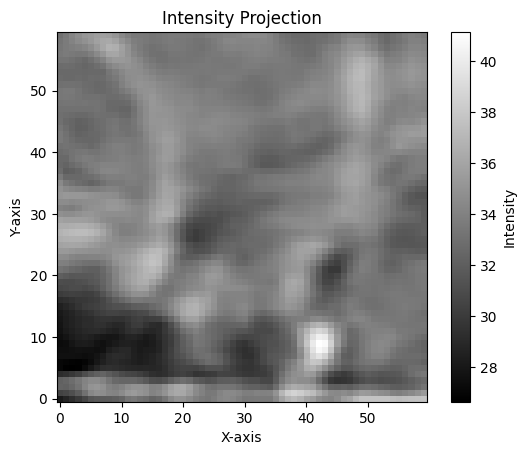

In [10]:
sample = dataset[0]

volume = sample['image'].squeeze(0)

direction = (0, 0, 1)
x_center, y_center, z_center = 80, 50, 0
x_range = range(x_center - 10, x_center + 50)
y_range = range(y_center - 20, y_center + 40)

sources = torch.tensor(
    [[x, y, z_center] for x in x_range for y in y_range], dtype=torch.float32
)

profiles = trace_rays(volume, sources, direction, num_samples=300)

# Compute the value of each ray
values = [compute_value(ray) for ray in profiles]

# Reshape values to match the grid size
values_grid = torch.tensor(values).view(len(x_range), len(y_range))

plt.imshow(values_grid.numpy(), cmap='gray', origin='lower')
plt.title("Intensity Projection")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.colorbar(label="Intensity")
plt.show()

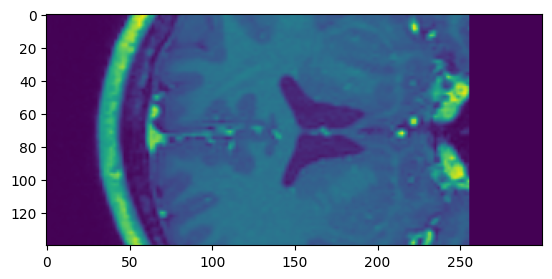

In [22]:
plt.imshow(profiles)

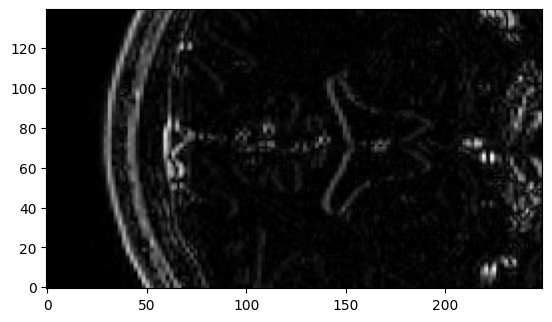

In [28]:
# let's render some depth imagery
starts_x = range(0, 140)
sources = [[x, 30, 0] for x in starts_x]

directions = [(0, 0, 1) for _ in sources]

num_samples = 250

profiles = trace_rays(volume, 
                      sources, 
                      direction, 
                      num_samples=num_samples
                      )

output = []
for i, profile in enumerate(profiles):
    delta = profiles[0][1:] - profiles[0][:-1]
    output.append(profile[1:] - profile[:-1])
    
# Compute the value of each ray
# values = [compute_value(ray) for ray in profiles]

# Reshape values to match the grid size
# values_grid = torch.tensor(values).view(len(starts_x), 1)

plt.imshow(np.abs(output), cmap='gray', origin='lower')
# plt.title("Intensity Projection")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.colorbar(label="Intensity")
# plt.show()



In [36]:
torch.tensor(directions).shape

torch.Size([1, 6])

In [58]:
volume.shape

torch.Size([256, 256, 256])

In [59]:
sources = torch.tensor([128, 128, 0])
thetas = np.radians(np.linspace(-45, 45, 64))  # 64 rays across the fan

directions = [np.array([np.sin(theta), 0, np.cos(theta)]) for theta in thetas]

num_samples = 250

def trace_ray_fan(volume, source, directions, num_samples):
    profiles = []
    for direction in directions:
        direction_tensor = torch.tensor(direction, dtype=torch.float32)
        profile = trace_ray(volume, source, direction_tensor, num_samples)
        profiles.append(profile)
    return torch.stack(profiles)  # shape: (N_rays, num_samples)

In [141]:
import numpy as np
from scipy.signal import hilbert

def process_rf_to_bmode(profiles):
    """
    Convert RF-like profiles to B-mode image.

    Args:
        profiles (torch.Tensor): (num_rays, num_samples)
    
    Returns:
        np.ndarray: B-mode image (normalized, log-compressed)
    """
    rf_np = profiles.cpu().numpy()
    envelope = np.abs(hilbert(rf_np, axis=1))  # analytic signal
    # envelope = np.abs(2*np.diff(rf_np, axis=1))
    bmode = np.log1p(envelope)  # log compression
    bmode = bmode / np.max(bmode)  # normalize to [0, 1]
    return bmode

def plot_bmode_image(bmode, title="Simulated B-mode Image"):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 6))
    plt.imshow(bmode.T, cmap='gray', aspect='auto', origin='lower')
    plt.xlabel("Scanline")
    plt.ylabel("Depth")
    plt.title(title)
    plt.colorbar(label='Echo Intensity')
    plt.show()


In [142]:
from scipy.ndimage import sobel

C:\Users\noe\AppData\Local\Temp\ipykernel_25156\1835963857.py:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\noe\AppData\Local\Temp\ipykernel_25156\1835963857.py:29: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



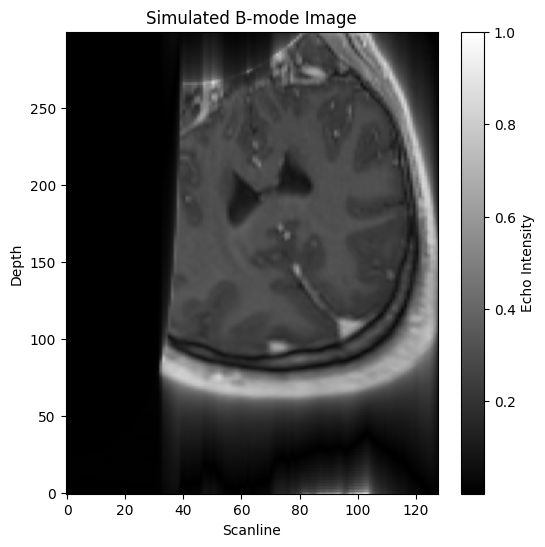

In [143]:
# Build fan directions
angles = np.radians(np.linspace(-30, 60, 128))
directions = [np.array([np.sin(a), 0, np.cos(a)]) for a in angles]
source = torch.tensor([10, 0, -10], dtype=torch.float32)

# Trace
profiles = trace_ray_fan(volume, source, directions, num_samples=300)

# Process to B-mode
bmode = process_rf_to_bmode(profiles)
# Display
plot_bmode_image(bmode)


C:\Users\noe\AppData\Local\Temp\ipykernel_25156\1835963857.py:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\noe\AppData\Local\Temp\ipykernel_25156\1835963857.py:29: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



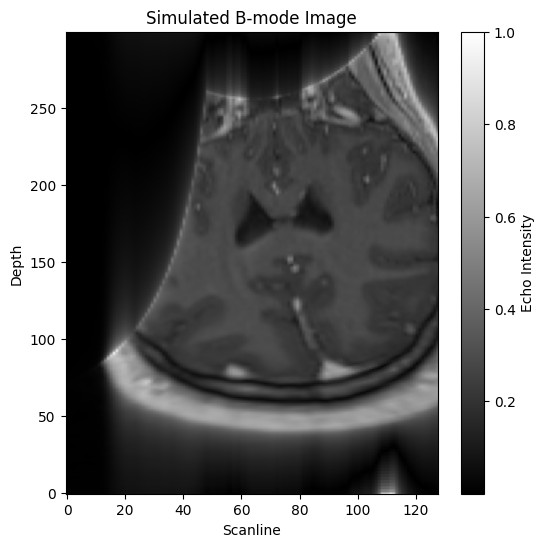

In [76]:
# Build fan directions
angles = np.radians(np.linspace(-45, 45, 128))
directions = [np.array([np.sin(a), 0, np.cos(a)]) for a in angles]
source = torch.tensor([50, 0, 0], dtype=torch.float32)

# Trace
profiles = trace_ray_fan(volume, source, directions, num_samples=300)

# Process to B-mode
bmode = process_rf_to_bmode(profiles)

# Display
plot_bmode_image(bmode)

In [111]:
US_file = iUSDataset(image_path / iUS_file, "iUS", axis=1)

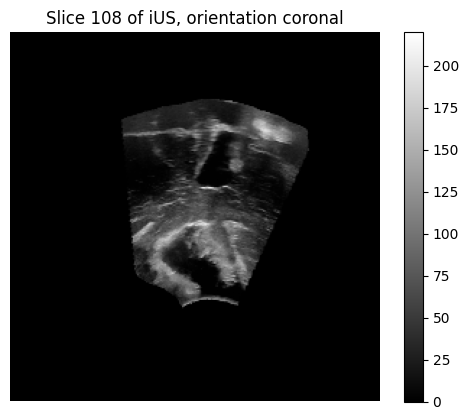

In [129]:
US_file.plot2D(108, axis=1)